# Bayesian Data Analysis - Project
___

__Note!__ The submitted notebooks need to illustrate the knowledge of the Bayesian workflow

__RUBRIC:__ 
* The introduction is inviting, presents an overview of the notebook. Information is relevant and presented in a logical order.
* The conclusion is clear
* The notebook presents a clear cohesive data analysis story, which is enjoyable to read
* Accuracy of use of statistical terms: Statistical terms are used accurately and with clarity 
* Description of the data, and the analysis problem
* Description of the model
* Description of the prior choices: Priors are listed and justiﬁed
* Is Stan code included?
* Is code for how Stan model is run included?
*  Is required convergence diagnostics (Rhat, divergences, neff) included?: Required onvergence diagnostic results shown and maning of the results is discussed
* Is there posterior predictive checking?
*  Is there a discussion of problems and potential improvements ?
___


## 1 Introduction

**Goal**: predict the outcome of a badminton match based on the ranking different between players

**Approach**: apply Bayesian data analysis on historical data of badminton tournaments. The estimand of interest is the probability of winning with a certain ranking spread.

**Implementation**:
* Start with some naive assumption of the estimand, in order to choose the model later
* Collect and preprocess data
* Decide on prior choices and models
* Do stan analysis on each models
* Model comparision (using PSIS-LOO)
* Do posterior predictive comparision between models
* Conclusion, possible improvements




## 2 Analysis problem

### 2.1 Discretizing the problem
In one tournament, there are 8 seed players and some unranked players. To discretize the ranking spread, we chose 12th as the rank for all unranked players. The spread is calculated as follows:

**Spread (from 1st player perspective) = Rank(2nd player) - Rank(1st player)**

E.g.

* Spread(from 1st rank player to 8th rank player) = 8 - 1 = 7
* Spread(from 2nd rank player to unrank player) = 12 - 2 = 10
* Spread(from unrank player to 3rd rank player) = 3 - 12 = -9

The discrete space for ranking spread is then **[-11,-10,-9,...,9,10,11]**

A match (which has at most 3 games) has 6 possible outcomes:
1. Lose Lose     -> Lose
2. Lose Win Lose -> Lose
3. Win Lose Lose -> Lose
4. Lose Win Win  -> Win
5. Win Lose Win  -> Win
6. Win Win       -> Win 

To discretize this parameter, we map the outcome of a match to **[1,2,3,4,5,6]** in terms of win degree (i.e. win degree 1 is the worst, and win degree 6 is the best)


For the match below, ranking spread is 11, win degree is 4

<img src="match_beautified.png" alt="match" style="width: 600px; margin-left: 0"/>

### 2.2 Modeling the problem

Unless stated otherwise, all information in the data are from 1st player perspective
An observation of a match includes 2 pieces of information:
* ranking spread
* win degree

To formulate the observations as a one dimensional space collection, we need to reduce the matrix 23x6 (23 different spreads, 6 different win degrees) of all possible raw observations. The intuition of the reduction is as follows:
* With the same ranking spread, higher win degree correlates to higher value (see arrow A in image below)
* With the same win degree, lower ranking spread correlates to higher value (see arrow B in image below)
* Step between value is 1

With the given constraint, we will have **46 possible values of observation from [1,46]**. The mapping is as follow (columns are win degrees and rows are ranking spreads)

<img src="mapping3.jpg" alt="mapping" style="width: 400px; margin-left: 0"/>

### 2.3 Analysing the problem

The analysis problem is the distribution of observations and how they differ between different tournaments. Furthermore, we will also try and the analyze the affect of different models and priors choice.


## 3 Dataset and data model

The dataset is collected from Badminton World Federation (BWF) tournament database using Scrapy crawler. After collecting, the data is preprocessed as stated in the previous section. In the end, the format of data is similar to the factory data assignments. A peek of the data:

In [8]:
show_first_rows_of_data()

,Tournament 1,Tournament 2,Tournament 3,Tournament 4,Tournament 5
Match 1,24.0,35.0,34.0,24.0,19.0
Match 2,33.0,33.0,35.0,31.0,35.0
Match 3,34.0,25.0,22.0,35.0,23.0
Match 4,33.0,31.0,35.0,35.0,31.0
Match 5,37.0,38.0,38.0,33.0,35.0


In [9]:
show_summary_of_data()

,Tournament 1,Tournament 2,Tournament 3,Tournament 4,Tournament 5
count,67.000000,67.000000,67.000000,67.000000,67.000000
mean,31.776119,32.388060,31.746269,32.880597,32.164179
std,5.746727,5.635266,5.329572,5.878885,5.703792
min,22.000000,21.000000,22.000000,21.000000,19.000000
25%,27.000000,28.000000,26.000000,28.000000,28.000000
50%,33.000000,33.000000,33.000000,34.000000,34.000000
75%,35.000000,36.000000,35.000000,35.000000,35.000000
max,43.000000,45.000000,44.000000,45.000000,45.000000


## 4 Prior choices

We decided to use two different priors: 
* **Inverse gamma** is chosen on variance because it is the conjugate prior to normal likelihood and it has a closed form solution for the outcome of the posterior
* **Uniform** is chosen as weak prior to observe how sensitive is outcome in regards the prior and the data input

## 5 Model

In normal distribution where $\mu$ is known and $\sigma^2$ is unknown, the marginal posterior distribution $p(\sigma^2|y)$ can be computed as described below. The posterior distribution is computed using two different priors, whereas the first is an uniformative (uniform) and the second an informative (inverse gamma) prior.

__Priors:__

Uniform prior

\begin{equation*}
p(\sigma^2) \propto Uniform(0, \infty)
\end{equation*}

Inverse gamma prior

\begin{equation*}  
p(\sigma^2) \propto (\sigma^2)^{-(a+1)}e^{-\beta/\sigma^2} \propto Inv-Gamma(\alpha, \beta) \\
\end{equation*}

where $\alpha$ and $\beta$ are the shape and scale parameters. __The values of the parameters ??__

__Likelihood:__
\begin{equation*}
p(y|\mu,\sigma^2) \propto \prod_{i=1}^{N} p(y_i | \mu, \sigma^2) \propto N(y | \mu, \sigma^2) 
\end{equation*}

where $\mu$ is known.

__Posterior:__

\begin{equation*}
p(\sigma^2 | y) \propto p(\sigma^2)p(y|\mu, \sigma^2)
\end{equation*}

Since one of the objective is to predict the distribution of a new tournament, we will use pooled and hierarchical model. The separate model is excluded because it handles the tournaments uniquely  without having any common parameters which could be used to predict the new tournament.

In the pooled model the mean and the variance is computed from the combined data of all the tournaments and there is no distinction between different tournaments. This means that also the new tournament will have similar distibution as the predictive distribution of the tournaments.  

In the hierarchical model each tournament is handled separately having own mean and common standard deviation. Furthermore, all the means are controlled by common hyperparameters ($\mu_0$ and $\sigma^2_0$) which means that the means are drawn from the common distribution described by these hyperparameters. The result of the new tournament can be predicted using the common hyperparameters: first draw the mean from the common distribution and use it to sample the predictive distribution. 

Then based on the prior choices, we have 4 different models:
* pooled with uniform prior
* pooled with inverse gamma prior for variance
* hierarchical with uniform prior
* hierarchical with inverse gamma prior for variance

## 6 Stan analysis of the models

For each model, we will show:
* Stan model
* Convergence diagnostics (rhat, divergences, neff)

Each model's fitting uses Stan's default parameters (4 chains, 1000 warmup iterations, 1000 sampling iteration, ending up to 4000 samples and 10 as maximum tree depth). To avoid false positive conclusion about divergences, the *adapt_delta* value is set to 0.9. This means that the fitting uses larger target acceptance probability and therefore all the divergences can be seen. If the resulting value is still 0 after this, we can verify that there are no divergences. If not, the divergences could be furter analyzed by increasing *adapt_delta*.

__Everything is fine based on these diagnostics and we can proceed with our analysis.__

### 6.1 Pooled model with uniform prior

#### Stan model

The stan code of the model:
```
fsk
```
#### Convergence diagnostic
After compiling the model and fitting the combined data of the tournaments, the diagnostic of the fit was examined:
* The $\hat R$ values of the parameters are close to 1 which describes that the fit was good. The low $\hat R$ values combined with high effective sample size (n_eff) per transition informs that the Markov chains were mixed well. 
* The value of the diveregences is 0 which informs that the Markov chains were able to explore the posterior.
* The value of tree depth is 0 which infroms that model is identified and the sampler is efficient.
* The value of the energy Bayesian fraction of missing information (E-BFMI) is missing which means that that the exploration of the posterior was fast (the jumps between slices of the parameter space explored by the Hamiltonian trajectories were fast).

All the results for pooled uniform prior model fitting are good.

__CHECK FROM ASSIGNMENT__

The full fit can be found in the _Attachment 1_ and a shorter summary is shown below.

In [140]:
# Fit pooled uniform model
pool_uni_df, pool_uni_fit = compute_model(r'stan_code/pool_uniform_prior.stan', pooled_data_model)
# Print summary of the fit
print_compact_fit(pool_uni_df)

Using cached StanModel


,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
mu,32.1949,0.00560523,0.314143,31.5688,31.9856,32.1993,32.4013,32.8212,3141,1.00008
sigma,5.66357,0.00441617,0.226175,5.25044,5.50777,5.65362,5.81066,6.12685,2623,1.0007
log_lik[0],-3.70566,0.00165465,0.0923644,-3.89379,-3.76673,-3.70203,-3.64212,-3.53527,3116,0.999738
log_lik[1],-2.66387,0.000782296,0.0400502,-2.74168,-2.69029,-2.66291,-2.63689,-2.58669,2621,1.00059
log_lik[2],-2.70474,0.000775921,0.0403031,-2.78298,-2.73239,-2.70432,-2.67709,-2.62805,2698,1.00029
...,...,...,...,...,...,...,...,...,...,...
log_lik[332],-2.70474,0.000775921,0.0403031,-2.78298,-2.73239,-2.70432,-2.67709,-2.62805,2698,1.00029
log_lik[333],-2.81365,0.000788474,0.0411293,-2.89514,-2.84058,-2.81256,-2.78528,-2.73606,2721,1.00086
log_lik[334],-3.46461,0.0013434,0.0752786,-3.6169,-3.5144,-3.46345,-3.41195,-3.32293,3140,0.999774
ypred,32.2848,0.0884854,5.59631,21.3153,28.5981,32.3413,36.1368,43.2205,4000,0.999686


In [142]:
print_compact_fit_checking(pool_uni_fit)

Divergences:
0.0 of 4000 iterations ended with a divergence (0.0%)

Tree depth:
0 of 4000 iterations saturated the maximum tree depth of 10 (0.0%)

E-BMFI:



### 6.2 Pooled model with inverse gamma prior

#### Stan model
The stan code of the model:
```
fsk
```

#### Convergence diagnostic
The same procedure is followed here (as in the previous section) and similar results were obtained:
* The $\hat R$ values of the parameters are close to 1 which describes that the fit was good. The low $\hat R$ values combined with high effective sample size (n_eff) per transition informs that the Markov chains were mixed well. 
* The value of the the divergences is 0
* The value of the tree depth is 0 
* The value of the E-BFMI is missing 

All of these verify that pooled inverse prior model fitting is successful.

The full fit can be found in the _Attachment 2_ and a shorter summary is shown below.

In [143]:
# Fit pooled inverse gamma model
pool_inv_df, pool_inv_fit = compute_model(r'stan_code/pool_inverse_gamma_prior.stan', pooled_data_model)
# Print summary of the fit
print_compact_fit(pool_inv_df)

Using cached StanModel


,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
mu,32.1793,0.00689492,0.308581,31.5691,31.9764,32.1832,32.3895,32.7701,2003,1.00044
sigmaSq,31.858,0.0473801,2.50443,27.362,30.0984,31.7234,33.4821,37.0895,2794,0.999906
sigma,5.63996,0.00417828,0.221133,5.23087,5.4862,5.63235,5.78637,6.09012,2801,0.999948
log_lik[0],-3.7059,0.00200909,0.0900062,-3.88675,-3.76447,-3.70524,-3.64415,-3.53603,2007,1.00084
log_lik[1],-2.66019,0.000746751,0.0391457,-2.73674,-2.68703,-2.66003,-2.63316,-2.58449,2748,1.00024
...,...,...,...,...,...,...,...,...,...,...
log_lik[332],-2.7019,0.000765716,0.0392163,-2.7779,-2.72741,-2.70094,-2.67566,-2.62586,2623,1.0005
log_lik[333],-2.80913,0.000834766,0.0409886,-2.89114,-2.83612,-2.80866,-2.78006,-2.72968,2411,0.999903
log_lik[334],-3.46338,0.00166824,0.0735351,-3.61101,-3.51234,-3.46225,-3.4125,-3.32343,1943,1.0008
ypred,32.2442,0.0901159,5.69943,21.0271,28.471,32.3129,36.0515,43.5248,4000,1.00019


In [145]:
print_compact_fit_checking(pool_inv_fit)

Divergences:
0.0 of 4000 iterations ended with a divergence (0.0%)

Tree depth:
0 of 4000 iterations saturated the maximum tree depth of 10 (0.0%)

E-BMFI:



### 6.3 Hierarchical model with uniform prior

#### Stan model
The stan code of the model:
```
fsk
```

#### Convergence diagnostic attempt 1
The same procedure is followed here (as in the previous section) with minor change. The data set used for fitting is a matrix where columns are the tournaments and rows are the matches in the tournaments. The diagnostic results are:
* The $\hat R$ values of the parameters are close to 1 (and below 1.1) which describes that the fit was good. As well, the low $\hat R$ values combined with high effective sample size (n_eff) per transition informs that the Markov chains were mixed well.
* The value of the the divergences is 75 which means that 2% of the target posterior was not explored by the Markov chains.
* The value of the tree depth is 0 
* The value of the E-BFMI is missing 

Because the divergences was too high, in the next step we will try to improve the results by reducing the accuracy of the simulations by adjusting the *adapt_delta* parameter.

The results of the attempt 1 can be seen below.

In [181]:
# Fit hierarchical uniform model
hier_uni_df, hier_uni_fit = compute_model(r'stan_code/hier_uniform_prior.stan', hierarchical_data_model)
# Print the summary of the fit
print_compact_fit(hier_uni_df)

Using cached StanModel


,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
mu0,32.1793,0.0123522,0.464316,31.2665,31.9203,32.1789,32.4496,33.0974,1413,1.00197
sigma0,0.595743,0.0224654,0.606149,0.0638678,0.233114,0.423122,0.753836,2.07877,728,1.00319
mu[0],32.0484,0.0122383,0.491822,30.9904,31.7589,32.0854,32.3603,32.9556,1615,1.00337
mu[1],32.2613,0.0105294,0.461614,31.3516,31.9774,32.2519,32.5348,33.2434,1922,1.00052
mu[2],32.0402,0.0126773,0.482736,31.0076,31.7547,32.073,32.352,32.9207,1450,1.00244
...,...,...,...,...,...,...,...,...,...,...
ypred[3],32.3063,0.0896909,5.67255,21.0681,28.3453,32.2987,36.1136,43.6567,4000,1.00016
ypred[4],32.1632,0.0916874,5.73614,20.9252,28.3002,32.2326,35.9441,43.3436,3914,1.00061
mu_new,32.1897,0.018286,0.954034,30.3259,31.8032,32.1852,32.5619,34.0576,2722,0.999919
ypred_new,32.2443,0.0943861,5.87928,21.1567,28.2786,32.2602,36.2773,43.6389,3880,1.00048


In [182]:
print_compact_fit_checking(hier_uni_fit)

Divergences:
75.0 of 4000 iterations ended with a divergence (1.875%)
Try running with larger adapt_delta to remove the divergences

Tree depth:
0 of 4000 iterations saturated the maximum tree depth of 10 (0.0%)

E-BMFI:



#### Convergence diagnostic attempt 2

After changing the accuracy of the simulations from 0.9 to 0.96, the data is re-fit and following results were gained:
* The $\hat R$ values of the parameters are close to 1 (and below 1.1) which describes that the fit was good. As well, the low $\hat R$ values combined with high effective sample size (n_eff) per transition informs that the Markov chains were mixed well.
* The value of the the divergences dropped to 1% which means that the Markov chains are exporing the posterior much better.
* The value of the tree depth is 0 
* The value of the E-BFMI is missing 

With these results we can verify that the hierarchical uniform prior model fitting is 99% successful. __I think we cannot use this model at all.... Should we try to modify the stan model????__

The full fit can be found in the _Attachment 3_ and a shorter summary of attempt 2 is shown below.

In [185]:
# Fit hierarchical uniform model
hier_uni_df, hier_uni_fit = compute_model(r'stan_code/hier_uniform_prior.stan', hierarchical_data_model, adapt_delta=0.96)
print_compact_fit(hier_uni_df)

Using cached StanModel


,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
mu0,32.1923,0.0127379,0.483707,31.2362,31.9264,32.1934,32.4579,33.1532,1442,1.0005
sigma0,0.60145,0.0202741,0.612936,0.0703005,0.23329,0.435138,0.758839,2.16422,914,1.00115
mu[0],32.0521,0.0116293,0.488015,31.02,31.7594,32.0775,32.3688,32.9608,1761,1.00112
mu[1],32.2586,0.0119162,0.479766,31.306,31.953,32.2553,32.5444,33.2942,1621,1.00058
mu[2],32.0339,0.0124034,0.504134,30.9425,31.7535,32.0615,32.3694,32.9244,1652,1.00104
...,...,...,...,...,...,...,...,...,...,...
ypred[3],32.4268,0.08923,5.6434,21.4007,28.6964,32.4846,36.136,43.5792,4000,0.999834
ypred[4],32.1169,0.0905623,5.72766,20.6597,28.3104,32.2082,35.9333,43.1799,4000,0.999926
mu_new,32.1926,0.0176988,0.930659,30.3461,31.8076,32.1933,32.5902,33.9828,2765,1.00043
ypred_new,32.241,0.0949073,5.79168,20.8495,28.4127,32.236,36.1046,43.4708,3724,0.999555


In [186]:
print_compact_fit_checking(hier_uni_fit)

Divergences:
45.0 of 4000 iterations ended with a divergence (1.125%)
Try running with larger adapt_delta to remove the divergences

Tree depth:
0 of 4000 iterations saturated the maximum tree depth of 10 (0.0%)

E-BMFI:



### 6.4 Hierarchical model with inverse gamma prior

#### Stan model

The stan code of the model:
```
fsk
```

#### Convergence diagnostic 

The data is fitted using 0.94 value for the *adapt_delta* and the results are as follows:
* The $\hat R$ values of the parameters are close to 1 (and below 1.1) which describes that the fit was good. As well, the low $\hat R$ values combined with high effective sample size (n_eff) per transition informs that the Markov chains were mixed well.
* The value of the the divergences dropped to 1% which means that the Markov chains are exporing the posterior much better.
* The value of the tree depth is 0 
* The value of the E-BFMI is missing  

With these results we can verify that the hierarchical uniform prior model fitting is 99% successful. __I think we cannot use this model at all.... Should we try to modify the stan model????__

The full fit can be found in the _Attachment 4_ and a shorter summary is shown below.

In [196]:
# Fit hierarchical uniform model
hier_inv_df, hier_inv_fit = compute_model(r'stan_code/hier_inverse_gamma_prior.stan', 
                                          hierarchical_data_model, adapt_delta=0.94)
print_compact_fit(hier_inv_df)

Using cached StanModel


,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
mu0,32.1827,0.0130185,0.462295,31.2777,31.9272,32.1865,32.4385,33.0798,1261,1.00136
sigma0,0.577608,0.0223943,0.633011,0.0692888,0.218582,0.406665,0.72989,2.04751,799,1.00004
mu[0],32.0703,0.0133654,0.490165,31.0218,31.7838,32.086,32.3829,32.9904,1345,1.00097
mu[1],32.261,0.0108749,0.458038,31.3905,31.9531,32.251,32.5581,33.2047,1774,1.00032
mu[2],32.0424,0.0118568,0.476931,30.9972,31.762,32.0664,32.3523,32.9155,1618,1.00002
...,...,...,...,...,...,...,...,...,...,...
ypred[3],32.4341,0.0898893,5.6851,21.2877,28.581,32.4428,36.3299,43.535,4000,1.00084
ypred[4],32.1469,0.0904786,5.69512,20.8676,28.4197,32.1721,36.0097,43.3458,3962,1.00049
mu_new,32.1816,0.0208125,1.05015,30.4033,31.7809,32.1827,32.5685,34.0621,2546,1.00049
ypred_new,31.9774,0.0910429,5.75806,20.8128,28.027,31.9613,35.8319,43.1925,4000,1.00032


In [197]:
print_compact_fit_checking(hier_inv_fit)

Divergences:
50.0 of 4000 iterations ended with a divergence (1.25%)
Try running with larger adapt_delta to remove the divergences

Tree depth:
0 of 4000 iterations saturated the maximum tree depth of 10 (0.0%)

E-BMFI:



## 7 Model comparision with PSIS-LOO and $P_{LOO-CV}$ 


* Model selection according to the hightest LOO-CV sum
* Reliability based on the _k_values: <0.7 ok, <0.5 good



__TO DO!__ The PSIS-LOO values of the models can be computed using provided _psisloo_ function. The function returns observation specific _k_-values and PSIS-LOO-CV values. In addition it return the sum of the PSIS-LOO-CV values, hence the sum of the LOO log desnities:

\begin{equation*}
lppd_{loo-cv} = \sum_{i=1}^{N} log \left( \frac{1}{S} \sum_{s=1}^{S} p(y_i|\theta^{is}) \right)
\end{equation*}

The estimated effective number of parameters ($P_{LOO-CV}$) in the model is computed as follows:

\begin{equation*}
p_{loo-cv} = lppd-lppd_{loo-cv} 
\end{equation*}

where $lppd$ is the sum of the log densities of the posterior draws:
\begin{equation*}
lppd = \sum_{i=1}^{N} log \left( \frac{1}{S} \sum_{s=1}^{S} p(y_i|\theta^{s}) \right)
\end{equation*}


All the PSIS-LOO values, estimated effective number of parameters and plotted _k_-values are shown below.


## 8 Posterior predictive checking 

* show predictive distributions
* show the observations of tournaments and their predictions
* show the obesrvations of new tournment and their predictions

### 8.1 Pooled uniform

### 8.2 Pooled inverse gamma

### 8.3 Hierarchical uniform

### 8.4 Hierarchical inverse gamma


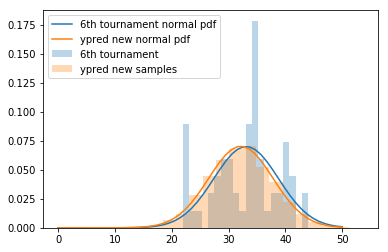

In [161]:
#Note that for hierarchical models, the new predictive tournament is computed from common hyperparatemers
# ypreds = [
#     pool_uni_fit.extract(permuted=True)['ypred'],     #Pooled unifrom new predictive tournament
#     pool_inv_fit.extract(permuted=True)['ypred'],     #Pooled inverse gamma new predictive tournament
#     hier_uni_fit.extract(permuted=True)['ypred_new'], #Hierarchical unifrom new predictive tournament 
#     hier_inv_fit.extract(permuted=True)['ypred_new']  #Hierarchical inverse gamma new predictive tournament
# ]
# ypreds_labels = ['Pooled uniform', 'Pooled inverse gamma', "Hierarchical uniform", "Hierarchical inverse gamma"]

#print("The predictive distributions of the models and the actual distribution")
#compare_new_predictive_against_actual_distribution(ypreds,pooled_data,ypreds_labels,'Original data set')


from scipy import stats

ypred = hier_inv_fit.extract(permuted=True)['ypred_new']
test_data = last
x = np.linspace(0,50, 50)
y = stats.norm(np.mean(test_data), np.std(test_data)).pdf(x)
plt.hist(test_data, bins=20, normed=True, alpha=0.3, label="6th tournament", color="C0")
plt.plot(x,y, label="6th tournament normal pdf", color="C0")

y2 = stats.norm(np.mean(ypred), np.std(ypred)).pdf(x)
plt.hist(ypred, bins=20, normed=True, alpha=0.3, label="ypred new samples", color="C1")
plt.plot(x,y2,label="ypred new normal pdf", color="C1")
plt.legend()
plt.show()


# fig, axes = plt.subplots(1, 1, sharey=True,figsize=(16,4), subplot_kw=dict(aspect='auto'))
# fig.suptitle('Predictive distributions of the blablabla')

# axes.scatter([i for i in range(len(pooled_data))],pooled_data,marker="o", color="C1", alpha=0.5)
# axes.scatter([i for i in range(len(pooled_data))],pooled_data,marker="x", color="C0")
# plt.show()


# the predictive distribution of all the models look similar, 
# therefore the prediction of the new tournament looks similar as the one which was left out

In [ ]:
"""CODE EXAMPLE FOR PLOTTING SEVERAL AXES, REMOVE IT IF NOT NEEDED!!!"""

#Show predictive distributions for all the machines and for new machine
def show_predictive_distributions(samples):
    m = 0;
   
    #First row of plots: machines from 1 to 4
    fig, axes = plt.subplots(1, 4, sharey=True,figsize=(16,4), subplot_kw=dict(aspect='auto'))
    fig.suptitle('Predictive distributions of the machines')
    for i in range(0,4):
        axes[i].set_title('Machine '+str(m+1))
        mu = np.mean(samples["ypred"][:,m])
        if mu<85:
            axes[i].hist(samples["ypred"][:,m],50, density=True, alpha=0.3, color='R')
        else:
            axes[i].hist(samples["ypred"][:,m],50, density=True, alpha=0.7)
        axes[i].plot([85,85],[0.027, 0],'-',color='K',linewidth=1.5, label=r'$\theta=85$')
        axes[i].plot([mu,mu],[0.027, 0],'--',color='K', linewidth=1.5, label=r'$\theta$ mean')
        m+=1
        axes[i].legend()
    plt.show()   


  


## 9 Sensitivity analysis (?)
* on the priors 
* and the model (ask ta)


## 10 Conclusion
* problems: 
 - data model is not 100& justifiable 
* potential improvements
 - data model can be modified so that multinomial can be used for likelihood
 - extensive experiment with binomial model
* discussion
 - it's accurate
* conclusion of the data analysis
* Is there a discussion of problems and potential improvements ?

___

# Source code

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

import pystan
import stan_utility
import psis
import plot_tools

# For hiding warnings that do not effect the functionality of the code
import warnings
warnings.filterwarnings('ignore')

In [151]:
# Data is provided as files, 1 file contains all matches result of a tournament
# We will use data from all tournaments to fit model
# Except for the last one which will be used to evaluate prediction accuracy
data = []
filenames = os.listdir(r'./data/')
for idx, filename in enumerate(filenames):
    col = np.loadtxt(f'data//{filename}').tolist()[0:67]
    if (idx == (len(filenames) - 1)):
        last = col[0:67]
    else:
        data.append(col)

np_data = np.array(data)

def show_first_rows_of_data():
    df = pd.DataFrame(np_data.T)
    df.columns=['Tournament '+str(i+1) for i in range(np_data.shape[0])]
    df = df.rename({i: 'Match '+str(i+1) for i in range(np_data.shape[1])}, axis='index')
    return df.head()

def show_summary_of_data():
    df = pd.DataFrame(np_data.T)
    df.columns=['Tournament '+str(i+1) for i in range(np_data.shape[0])]
    return df.describe()

# print number of observations (matches) and number of predictors (tournaments)

def print_model(file_path):
    with open(file_path) as file:
        print(file.read())

pooled_data = np_data.flatten()
pooled_data_model = dict(N=len(pooled_data), y=pooled_data, alpha=1, beta=1)

pooled_inv_g_data_model = dict(N=len(pooled_data), y=pooled_data)

hierarchical_data_model = dict(N = np_data.shape[1], J= np_data.shape[0],y = np_data.T, alpha=1, beta=1)
# choosing alpha and beta?

'''
adapt_delta: 0...1
    Effects to divergences, hence to the accuracy of the posterior. 
    The smaller the value is the more strict the Stan model is in accepting sampels.
    The bigger the value is the easier the Stan model accepts samples. 
'''
def compute_model(file_path, data, chains=4, iter=2000, adapt_delta=0.9):
    # Compile model for both separated and pooled
    model = stan_utility.compile_model(file_path) 

    # Fit model: adapt_delta is used for divergences
    fit = model.sampling(data=data, seed=194838,chains=chains, iter=iter, control=dict(adapt_delta=adapt_delta))
    #stan_utility.check_treedepth(fit)
    #stan_utility.check_energy(fit)
    #stan_utility.check_div(fit)

    # get summary of the fit, use pandas data frame for layout
    summary = fit.summary()
    df = pd.DataFrame(summary['summary'], index=summary['summary_rownames'], columns=summary['summary_colnames'])
    
    return df, fit

def print_compact_fit(fit_df, number_of_rows_head=5, number_of_rows_tail=5):
    df = fit_df.head(number_of_rows_head)
    df = df.append([{'mean':'...','se_mean':'...','sd':'...','2.5%':'...','25%':'...',
                   '50%':'...','75%':'...','97.5%':'...','n_eff':'...','Rhat':'...'}])
    df = df.rename({0: '...'}, axis='index')
    df = df.append(fit_df.tail(number_of_rows_tail))
    return df

def print_compact_fit_checking(fit):
    # Check divergences
    print("Divergences:")
    stan_utility.check_div(fit)
    print("")

    # Check tree depth
    print("Tree depth:")
    stan_utility.check_treedepth(fit)
    print("")

    # Check E-BMFI
    print("E-BMFI:")
    stan_utility.check_energy(fit)
    print("")

def compare_new_predictive_against_actual_distribution(new_preds, actual, new_pred_labels, actual_label):
    fig, axes = plot_tools.hist_multi_sharex(
        [new_preds[i] for i in range(len(new_preds))]+[actual],
        rowlabels= [ new_pred_labels[i] for i in range(len(new_pred_labels))]+[actual_label],
        n_bins=30,x_lines=np.mean(actual),figsize=(7, 10) )
    plt.show()
    

def compare_psis_loo(log_liks):
    ## compute psis_loo, p_eff
    ## plot k-values
    pass


___

# Attachment 1: Fit of pooled model with uniform prior

In [ ]:
print(pool_uni_fit)

___

# Attachment 2: Fit of pooled model with inverse gamma prior

In [ ]:
print(pool_inv_fit)

___

# Attachment 3: Fit of hierarchical model with uniform prior

In [95]:
print(hier_uni_fit)

Inference for Stan model: anon_model_4dbddebd54b18baabe527e1d9f8ac5b1.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu0            32.15    0.03   0.44  31.32   31.9  32.12  32.42  33.06    259   1.01
sigma0          0.61    0.04   0.51   0.15   0.27   0.44   0.75   1.93    190   1.01
mu[0]          31.99    0.02   0.48   31.0  31.71   32.0  32.28  32.96    530   1.01
mu[1]          32.23    0.02   0.48  31.34   31.9   32.2  32.52  33.22    381   1.01
mu[2]           32.0    0.02   0.47  31.04  31.74   32.0  32.29  32.92    866    1.0
mu[3]          32.38    0.04   0.52  31.43  32.01  32.32  32.71  33.53    166   1.02
mu[4]          32.14    0.02   0.49  31.23  31.81  32.16  32.43  33.16    427   1.01
sigma           5.66    0.02   0.22   5.28   5.51   5.64   5.79   6.09    155   1.01
log_lik[0,0]   -3.66  5.8e-3   0.13  -3.92  -3

___

# Attachment 4: Fit of hierarchical model with inverse gamma prior

In [ ]:
print(hier_inv_fit)

___

REMOVE EVERYTHING STARTING HERE!

In [24]:
raw_data = np.loadtxt('data.txt')

# Aggregate raw result
aggregated_result = {}
for i in range(-11,12):
    aggregated_result[str(i)] = []

for (spread, result) in raw_data:
    key = str(int(spread))
    aggregated_result[key].append(result)
        
# Turn to 23 x 3 matrix, where columns are win, lose, number of games, and rows are the possible spread
data_matrix = []
for key, value in aggregated_result.items():
    total = len(value)
    win = len([i for i in value if i > 0])
    data_matrix.append([win, total - win, total])

print(data_matrix)
print(len(data_matrix))
print(aggregated_result)

[[0, 0, 0], [13, 0, 13], [8, 0, 8], [9, 0, 9], [7, 0, 7], [10, 0, 10], [11, 0, 11], [11, 0, 11], [6, 0, 6], [3, 0, 3], [6, 0, 6], [30, 0, 30], [0, 0, 0], [8, 0, 8], [5, 0, 5], [14, 0, 14], [15, 0, 15], [16, 0, 16], [8, 0, 8], [4, 0, 4], [6, 0, 6], [0, 0, 0], [21, 0, 21]]
23
{'-11': [], '-10': [1.0, 1.0, 2.0, 2.0, 1.0, 6.0, 3.0, 1.0, 1.0, 1.0, 6.0, 5.0, 1.0], '-9': [6.0, 5.0, 1.0, 3.0, 1.0, 1.0, 1.0, 2.0], '-8': [3.0, 1.0, 1.0, 1.0, 3.0, 1.0, 1.0, 1.0, 4.0], '-7': [1.0, 1.0, 2.0, 3.0, 6.0, 4.0, 1.0], '-6': [1.0, 6.0, 2.0, 1.0, 1.0, 1.0, 5.0, 3.0, 4.0, 1.0], '-5': [2.0, 1.0, 1.0, 6.0, 2.0, 1.0, 4.0, 1.0, 1.0, 1.0, 6.0], '-4': [3.0, 1.0, 1.0, 6.0, 6.0, 6.0, 1.0, 1.0, 3.0, 4.0, 4.0], '-3': [4.0, 4.0, 5.0, 6.0, 3.0, 6.0], '-2': [1.0, 6.0, 5.0], '-1': [6.0, 6.0, 1.0, 1.0, 3.0, 5.0], '0': [6.0, 4.0, 6.0, 5.0, 6.0, 6.0, 6.0, 6.0, 5.0, 6.0, 6.0, 6.0, 6.0, 5.0, 6.0, 5.0, 6.0, 5.0, 6.0, 4.0, 6.0, 6.0, 5.0, 6.0, 4.0, 5.0, 6.0, 5.0, 6.0, 4.0], '1': [], '2': [4.0, 6.0, 4.0, 3.0, 5.0, 1.0, 2.0, 6.0],

In [ ]:
# Read data and convert it to matrix with dimensions [6x23]
raw_data = pd.read_csv('data.txt', sep=" ", header=None)
raw_data.columns = ['spread','win']
raw_data = raw_data.groupby(['spread', 'win']).size().reset_index(name='counts')


data_json = {i: [0 for j in range(-11,12)] for i in range(1,7)}
for index, row in raw_data.iterrows():
    data_json[row['win']][11+row['spread']] = row['counts']

data = pd.DataFrame(data=data_json)
def getRowText():
    j=-11
    c = {}
    for i in range(0,23):
        c[i] = j
        j += 1
    return c

data.rename(index=getRowText(), inplace=True)
data = data.T
print(data)

In [ ]:
def convertData(dataset):
    win = dataset[0:3].sum(axis=0).values 
    lose = dataset[3:7].sum(axis=0).values 
    return np.array([win,lose])

tt = convertData(data)


In [ ]:
# Data #######
raw_data = pd.read_csv('kristel.txt', sep=" ", header=None)
print(raw_data)


highest_frequency = max([8,8,7,7,6,6,5,5,4,3,2])+2
#data = dict(N=11, n=[highest_frequency for i in range(0,11)], 
#            y=np.array(list(reversed([8,8,7,7,6,6,5,5,4,3,2]))), x=[1,2,3,4,5,6,7,8,9,10,11])
data = dict(r=23, c=3, y=data_matrix)

def fit_model(model_code='stan_code\\binom-logistic-regression.stan'):
    model = stan_utility.compile_model(model_code)
    fit = model.sampling(data=data, seed=194838, chains=4, iter=4000)
    samples = fit.extract(permuted=True)
    print(fit)
    stan_utility.check_treedepth(fit)
    stan_utility.check_energy(fit)
    stan_utility.check_div(fit)
    return samples

In [ ]:
# Models
with open('stan_code\\binom-logistic-regression.stan') as file:
    print(file.read())

In [ ]:
# logistic_samples = fit_model('stan_code\\binom-logistic-regression.stan')

In [ ]:
logistic_samples = fit_model('stan_code\\multinomial.stan')

In [ ]:
####### Multinomial #######






In [ ]:
def show_model_fit(x, y, mu):    
    figsize = plt.rcParams['figure.figsize'].copy()
    figsize[0] *= 2  # width
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # scatterplot and lines
    color_scatter = 'C0'  # 'C0' for default color #0
    color_line = 'C1'     # 'C1' for default color #1
    # lighten color_line
    color_shade = (1 - 0.1*(1 - np.array(mpl.colors.to_rgb(color_line))))
    # plot
    ax.fill_between(
        x,
        np.percentile(mu, 5, axis=0),
        np.percentile(mu, 95, axis=0),
        color=color_shade
    )
    ax.plot(
        x,
        np.percentile(mu, 50, axis=0),
        color=color_line,
        linewidth=1
    )
    ax.scatter(x, y, 5, color=color_scatter)
    ax.set_xlabel('Spread')
    ax.set_ylabel('Normalized frequency')
    ax.set_title('Wins per spread')
    plt.show()
    
show_model_fit(data["x"],data["y"]/np.array([highest_frequency]), logistic_samples['p'])

In [ ]:
"""from scipy import stats
for i in range(0,11):
    mu = np.mean(logistic_samples['y_rep'][:,i])
    std = np.std(logistic_samples['y_rep'][:,i])
    x = np.linspace(0,11,100)
    plt.plot(x, stats.norm(mu,std).pdf(x))
    #plt.hist(logistic_samples['y_rep'][:,i], alpha=0.2, density=True)
plt.show()
"""


plt.scatter(logistic_samples["alpha"],logistic_samples["beta"])
plt.show();
plt.hist(logistic_samples["alpha"], bins=50)
plt.hist(logistic_samples["beta"], bins=50)
plt.show();

"""plt.scatter(data["x"],data["y"]/np.array([highest_frequency]))
def calc(a,b,xp):
    return np.exp(a + b*xp)/(1 + np.exp(a + b*xp))"""

FOR PSISLOO IF NEEDED

In [ ]:
# LPPD: Posterior predictive distribution summarized by the simulation draws of theta^s
def compute_LPPD(samples):
    lppd_all = 0
    samples = np.array(samples)
    N = samples.shape[1]
    S = samples.shape[0]
    for i in range(0,N):
        lppd_all += np.log(np.sum(np.exp(samples[:,i]))/S)
    return lppd_all

# LPPD LOO-CV: Bayesian loo-cv (leave-one-out cross-validation) estimate of out-of-sample predictive fit
def compute_PSIS_LOO_values_and_plot_k(samples, model_text='Separate model'):
    # Compute bayesian loo-cv using psisloo function
    lppd_loo_cv, lppd_loos_cv, lppd_loo_k = psis.psisloo(samples)

    #Estimate of the effective number of parameters
    p_loo_cv = compute_LPPD(samples) - lppd_loo_cv
    
    # Plot k-values
    plt.scatter(range(0,samples.shape[1]),lppd_loo_k,label=model_text, alpha=0.7)
    
    return {'loo_cv':lppd_loo_cv, 'loos_cv':lppd_loos_cv, 'loo_k':lppd_loo_k, 'p_loo_cv': p_loo_cv}

#Reshape matrix of [SxNxJ] to [Sx(N*J)]
def reshape_array(samples):
    samples_all = np.array(samples)
    S = samples_all.shape[0]
    N = samples_all.shape[1]
    J = samples_all.shape[2]
    samples_reshaped = []
    for s in range(0,S):
        temp = []
        for n in range(0,N):
            for j in range(0,J):
                temp.append(samples_all[s,n,j])
        samples_reshaped.append(temp)
    return np.array(samples_reshaped)


#samples = sfit.extract(permuted=True)
#compute_PSIS_LOO_values_and_plot_k(reshape_array(samples["log_lik"]))

# check the number of large (> 0.5) Pareto k estimates
#np.sum(ks1 > 0.5)